In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

## Loading in data

We start with simply loading in the data, for this case I used an excel sheet. You can also download this data from Kaggle. We then visualize the data to get a general understanding of what we are looking at.
https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [ ]:
pjme = pd.read_excel(r"C:\Users\Owner\Documents\Python\Data\HourlyEnergy\PJME2_hourly.xlsx", index_col=[0], parse_dates=[0])

#### Visualizing the data

Here, we see the dataset where each point represents an hour in the time sheet. It tells us we are working with a cyclical pattern of flucating demand that is consistent throughout the years.

<Axes: title={'center': 'PJM East'}, xlabel='Datetime'>

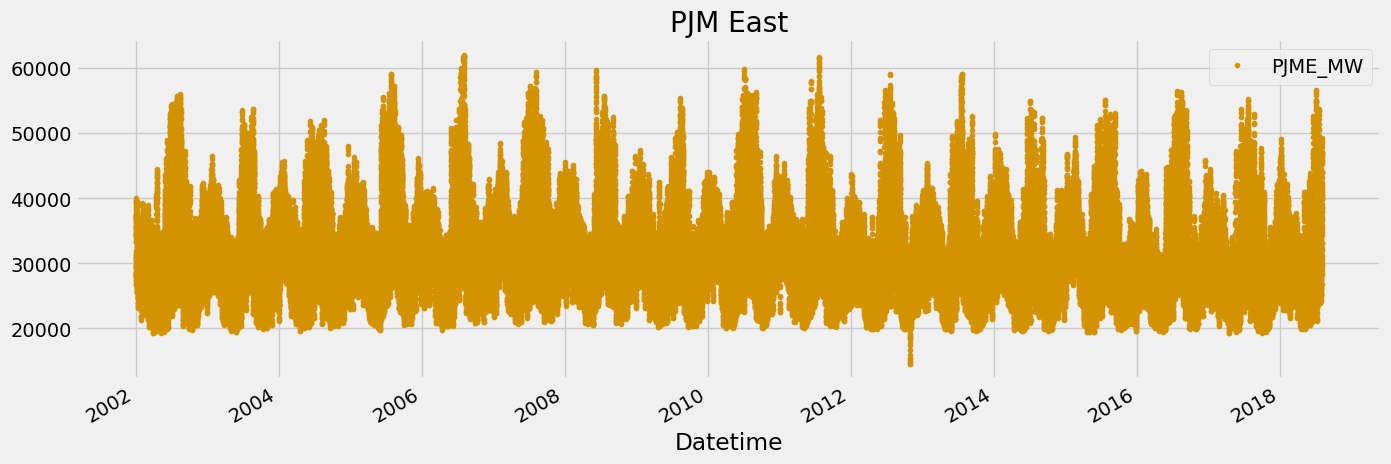

In [ ]:
pjme.plot(style='.', figsize=(15,5), color="#D39200", title='PJM East')

## Splitting Data between train and test

Splitting the data into training and testing sets is the first step in building and evaluating our model. The goal is to ensure that the model is trained on one portion of the data and tested on another, which helps evaluate its performance on unseen data. For our example, we are going to aim for a 80/20 split, 80% used for training, 20% used for testing it. 

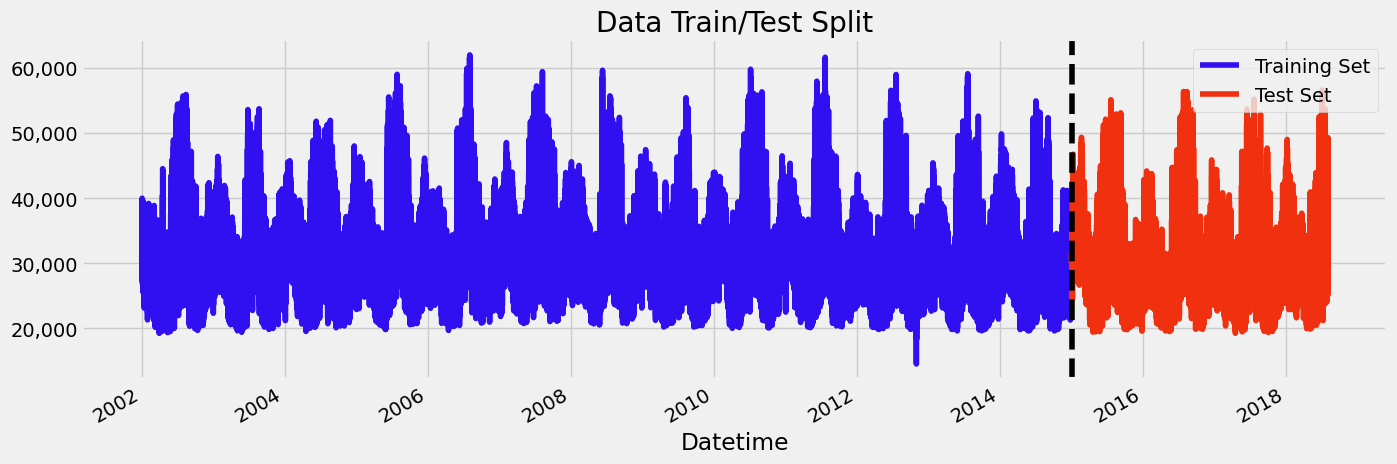

In [ ]:
from matplotlib.ticker import FuncFormatter

def comma_format(x, pos):
    return f'{x:,.0f}'

pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

fig, ax = plt.subplots(figsize=(15, 5))
pjme_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color='#300FF0')
pjme_test.plot(ax=ax, label='Test Set', color='#F0300F')
ax.axvline('01-01-2015', color='black', ls='--')
ax.yaxis.set_major_formatter(FuncFormatter(comma_format))

ax.legend(['Training Set', 'Test Set'])
plt.show()


## Feature Engineering 

## Feature Engineering: Creating Time Series Features

Feature engineering is an essential step in preparing data for machine learning models. It involves transforming raw data into meaningful features that enhance the model's ability to learn patterns and make accurate predictions. This code focuses on creating time-related features from a dataset with a datetime index.

### Purpose of Feature Engineering

Time series data often contains hidden temporal patterns, such as daily, weekly, or seasonal trends. By extracting these patterns into distinct features, we can help the model better understand how time affects the target variable. 

### What Features Are Created?

1. **Hour**: The hour of the day, useful for identifying daily trends or time-of-day effects (e.g., peak energy usage in the evening).
2. **Day of the Week**: Indicates the day (0 = Monday, 6 = Sunday), capturing weekly trends such as increased activity on weekdays.
3. **Quarter**: Identifies the quarter of the year (1 to 4), which can capture seasonal effects.
4. **Month**: The month of the year (1 to 12), which can reveal monthly seasonality or trends.
5. **Year**: The year of the data, capturing long-term trends or changes over multiple years.
6. **Day of the Year**: The day number within the year (1 to 365/366), useful for detecting annual patterns.
7. **Day of the Month**: The specific day within a month (1 to 31), which might relate to monthly periodic behavior.
8. **Week of the Year**: The week number in a year, capturing broader weekly patterns.

### Why These Features Matter

- **Improved Model Accuracy**: Time features allow the model to better capture temporal relationships in the data, which is especially important in time series forecasting.
- **Interpretability**: By decomposing time into granular components, it becomes easier to analyze the relative importance of different temporal patterns.
- **Support for Complex Models**: Many machine learning models, like tree-based methods, benefit from numerical features that provide structure to the data.

### Output of the Function

- **Input Features (`X`)**: The function returns a DataFrame containing all the extracted time features, ready for model training.
- **Optional Target Variable (`y`)**: If a label column is specified, the function returns the corresponding target values alongside the features. This is useful for supervised learning tasks.

This feature engineering approach ensures the dataset is enriched with temporal insights, paving the way for more robust and interpretable predictions.

In [7]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week  
    
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

# XGBoost Model

## Training and Evaluating a Model with XGBoost

XGBoost (Extreme Gradient Boosting) is a highly efficient and scalable machine learning algorithm, widely used for its performance in regression and classification tasks. This code demonstrates how to train an XGBoost model for a regression task using a structured dataset.

### Steps in the Process

1. **Data Preparation**:
   - The features and target variables for both training and testing datasets are converted into XGBoost’s `DMatrix` format (`dtrain` and `dtest`). This optimized data structure improves training efficiency.

2. **Defining Model Parameters**:
   - **`objective`**: Specifies the learning task. In this case, `reg:squarederror` is used for regression tasks.
   - **`eval_metric`**: The evaluation metric, here Root Mean Squared Error (RMSE), measures the model's prediction accuracy. Lower RMSE menas the model’s predictions are closer to the actual values, meaning better performance. Higher RMSE means the model's predictions are farther from the actual values, meaning worse performance.
   - **`n_estimators`**: Sets the maximum number of boosting rounds (trees) to 1000.   

3. **Early Stopping**:
   - To prevent overfitting and save computation time, `early_stopping_rounds=50` halts training if the test metric doesn’t improve for 50 consecutive rounds.

4. **Model Training**:
   - The `xgb.train` function is used to train the model. Training continues for a maximum of 1000 boosting rounds or until early stopping is triggered.

5. **Prediction and Evaluation**:
   - **RMSE** is computed to quantify the model's performance

### Why Use XGBoost?

- **Speed and Efficiency**: XGBoost is optimized for fast computation, making it ideal for large datasets.
- **Regularization**: It incorporates L1 and L2 regularization to reduce overfitting.
- **Early Stopping**: Automatically detects when additional training no longer improves performance, saving resources.
- **Tree-Based Learning**: Suitable for non-linear and complex relationships in the data.


By leveraging XGBoost's capabilities, this approach delivers a strong baseline for regression tasks while maintaining scalability and flexibility.


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "n_estimators": 1000,
}

evals = [(dtrain, "train"), (dtest, "test")]

# Train with early stopping
model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals,
                  early_stopping_rounds=50, verbose_eval=False)

# Make predictions
y_pred = model.predict(dtest)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

c:\Users\Owner\miniforge3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:59:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


RMSE: 4156.559301971699


c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Feature Importance

Feature Importance measures the level of influence a feature has on the outcome of its predictions. This metric is evaluated by the Frequency Score (F-Score), it gives a straightforward measure of a feature's relevance in the model. This information lets us refine the model to focus on the factors that make the biggest difference in its prediction decisions. For our case, we see 'day of year' and 'year' having the largest score of importance by far, with 'hour' just more than half of the same score as the most important. What is interesting is, given that the training data is over a 13 year timespan, it may be understanding the patterns of seasonality by the sequence of each day throuhgout the year. 

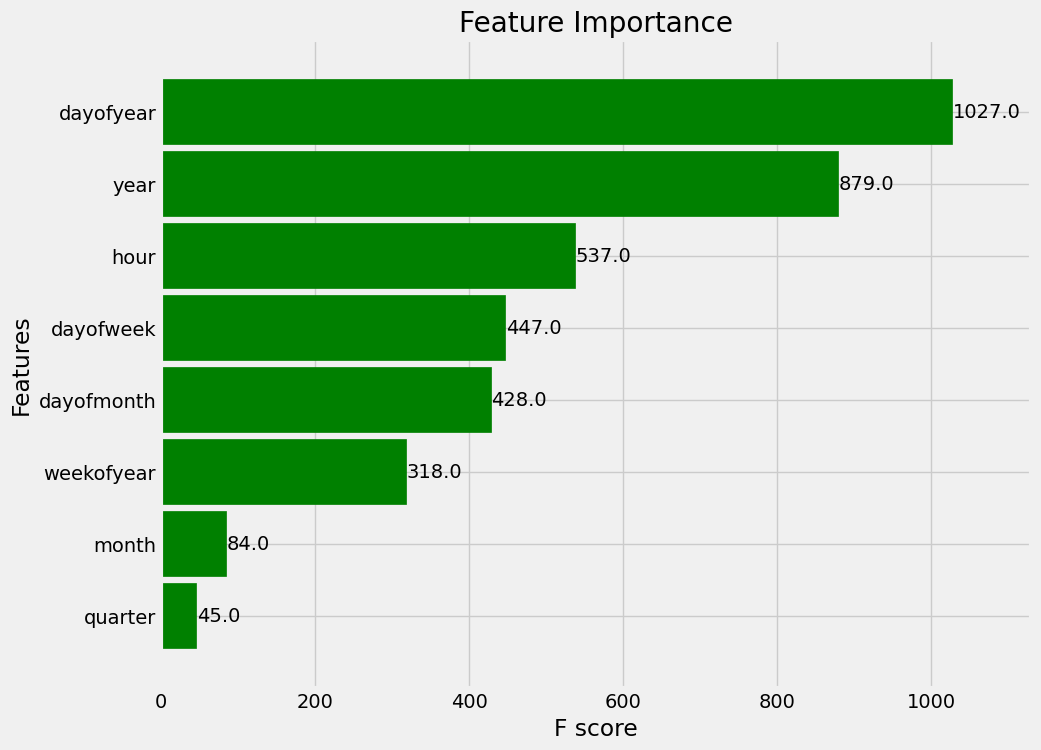

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, height=0.9, ax=ax)

for bar in ax.patches:
    bar.set_color('green')

plt.title("Feature Importance")
plt.show()

## Forecasting

In [11]:
dtest = xgb.DMatrix(X_test)  # Convert X_test to DMatrix
pjme_test['MW_Prediction'] = model.predict(dtest)  # Use the DMatrix for prediction
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

## Testing

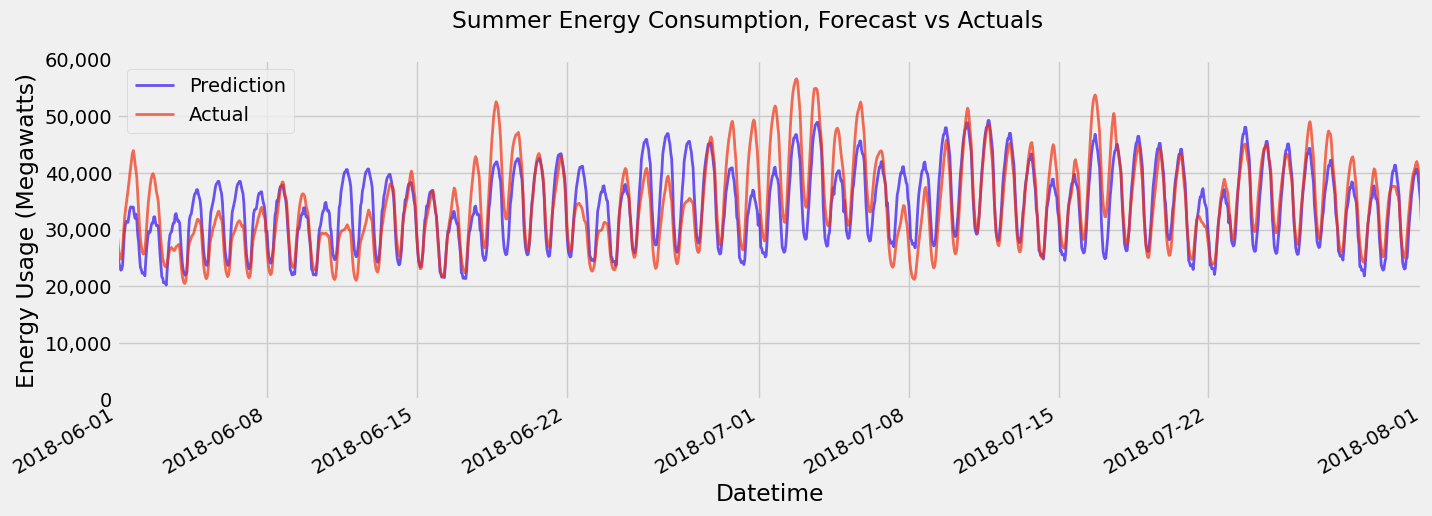

In [54]:
def comma_format(x, pos):
    return f'{x:,.0f}'

# Rename columns for clarity
pjme_all = pjme_all.rename(columns={
    'MW_Prediction': 'Prediction',
    'PJME_MW': 'Actual'
})

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

pjme_all[['Prediction', 'Actual']].plot(
    ax=ax,
    style=['-', '-'],
    alpha=0.7,  # Set transparency
    linewidth=2,  # Set thinner line width
    color=['#300FF0', '#F0300F']  # Set custom colors for Prediction and Actual
)

ax.set_xbound(lower='06-01-2018', upper='08-01-2018')
ax.set_ylim(0, 60000)

# Add comma delineation to y-axis
ax.yaxis.set_major_formatter(FuncFormatter(comma_format))

# Add y-axis label
ax.set_ylabel('Energy Usage (Megawatts)')

# Add plot title
plot = plt.suptitle('Summer Energy Consumption, Forecast vs Actuals')

plt.show()

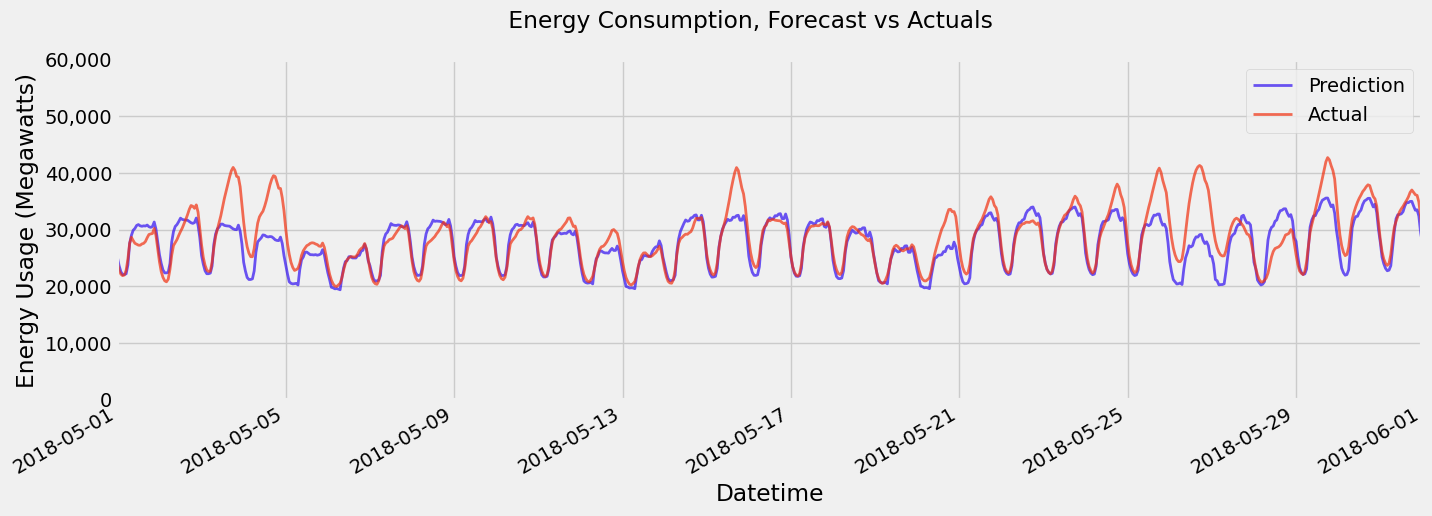

In [57]:
def comma_format(x, pos):
    return f'{x:,.0f}'

# Rename columns for clarity
pjme_all = pjme_all.rename(columns={
    'MW_Prediction': 'Prediction',
    'PJME_MW': 'Actual'
})

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

pjme_all[['Prediction', 'Actual']].plot(
    ax=ax,
    style=['-', '-'],
    alpha=0.7,  # Set transparency
    linewidth=2,  # Set thinner line width
    color=['#300FF0', '#F0300F']  # Set custom colors for Prediction and Actual
)

ax.set_xbound(lower='05-01-2018', upper='06-01-2018')
ax.set_ylim(0, 60000)

# Add comma delineation to y-axis
ax.yaxis.set_major_formatter(FuncFormatter(comma_format))

# Add y-axis label
ax.set_ylabel('Energy Usage (Megawatts)')

# Add plot title
plot = plt.suptitle(' Energy Consumption, Forecast vs Actuals')

plt.show()

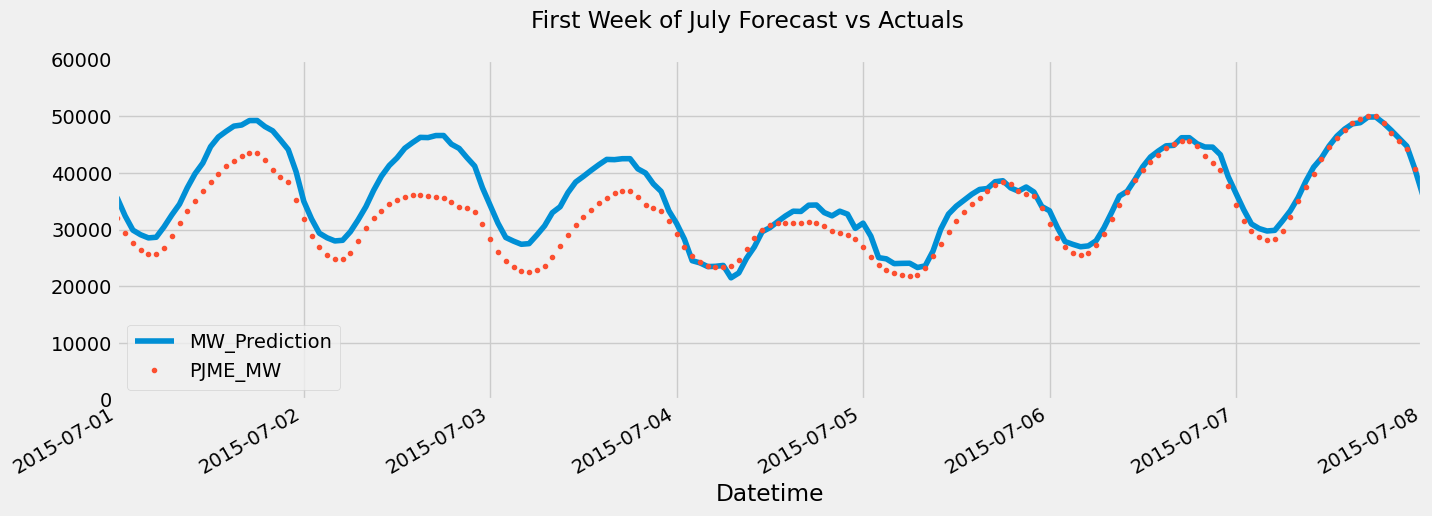

In [319]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [320]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

17276985.230807453

In [321]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

3120.0903155838487

In [322]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [323]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

9.766543766076746

In [324]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [325]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2017 9     2           24201.458333   36049.105469 -11847.645345  11847.645345
2018 1     23          29773.833333   41281.238281 -11507.406087  11507.406087
2017 1     25          30449.333333   41690.902344 -11241.568522  11241.568522
     9     1           27280.500000   38439.914062 -11159.414551  11159.414551
     1     26          30215.916667   41033.621094 -10817.702799  10817.702799
     9     3           24385.625000   34442.925781 -10057.301676  10057.301676
2018 1     24          32071.458333   41726.613281  -9655.153971   9655.153971
           28          27356.541667   36929.058594  -9572.518392   9572.518392
           22          29872.041667   39009.187500  -9137.146810   9137.146810
2017 1     27          31704.875000   40781.027344  -9076.152344   9076.152344

In [326]:
error_by_day.sort_values('abs_error', ascending=False).tail(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 8     8           36256.041667   36072.886719  183.153971  383.300781
     10    2           24659.083333   24727.171875  -68.087402  381.298665
2015 9     23          28634.708333   28832.201172 -197.492350  368.373210
2017 10    22          23570.958333   23655.595703  -84.637777  365.479899
     4     21          26598.375000   26398.250000  200.124919  338.416423
     10    14          24949.583333   24834.638672  114.945557  331.337158
2015 10    25          24141.916667   24341.710938 -199.794515  330.737061
2017 4     22          24219.083333   24349.701172 -130.616211  309.750326
2015 5     15          26923.083333   26835.146484   87.937500  306.340983
2016 5     14          23957.708333   24063.312500 -105.603841  300.724447

## Visualizations for LinkedIn

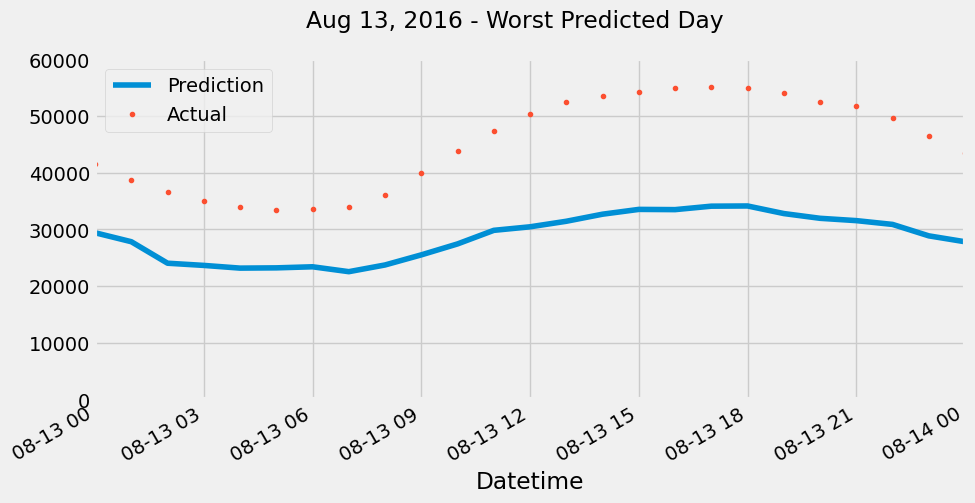

In [388]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['Prediction','Actual']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

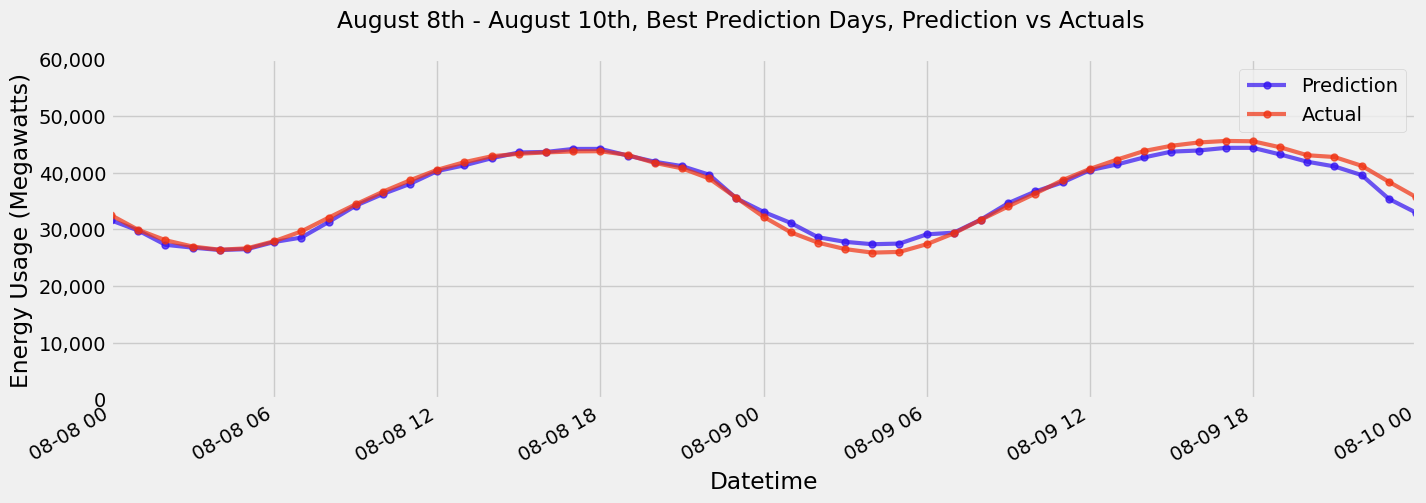

In [433]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

def comma_format(x, pos):
    return f'{x:,.0f}'

# Rename columns for clarity
pjme_all = pjme_all.rename(columns={
    'MW_Prediction': 'Prediction',
    'PJME_MW': 'Actual'
})

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

pjme_all[['Prediction', 'Actual']].plot(
    ax=ax,
    style=['-o', '-o'],  # Add circular markers to the lines
    alpha=0.7,  # Set transparency
    linewidth=3,  # Set line width
    markersize=5,  # Set marker size
    color=['#300FF0', '#F0300F']  # Set custom colors for Prediction and Actual
)

ax.set_xbound(lower='08-08-2016', upper='08-10-2016')
ax.set_ylim(0, 60000)

# Add comma delineation to y-axis
ax.yaxis.set_major_formatter(FuncFormatter(comma_format))

# Add y-axis label
ax.set_ylabel('Energy Usage (Megawatts)')

# Add plot title
plot = plt.suptitle('August 8th - August 10th, Best Prediction Days, Prediction vs Actuals')

plt.show()


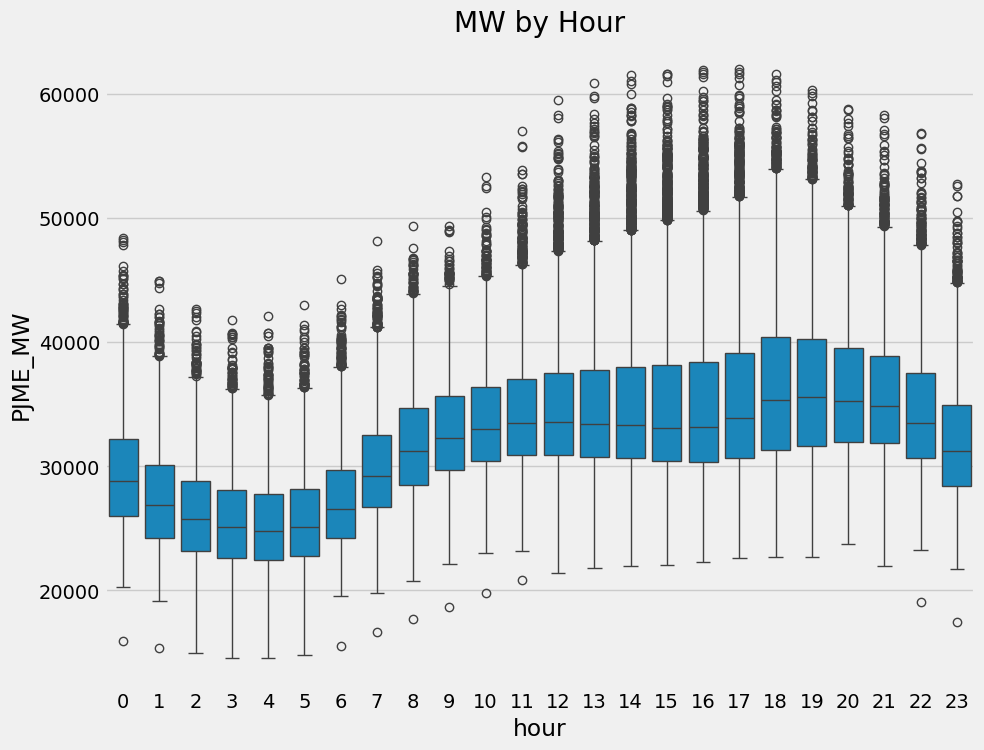

In [329]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=pjme_all, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_41908\587274234.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


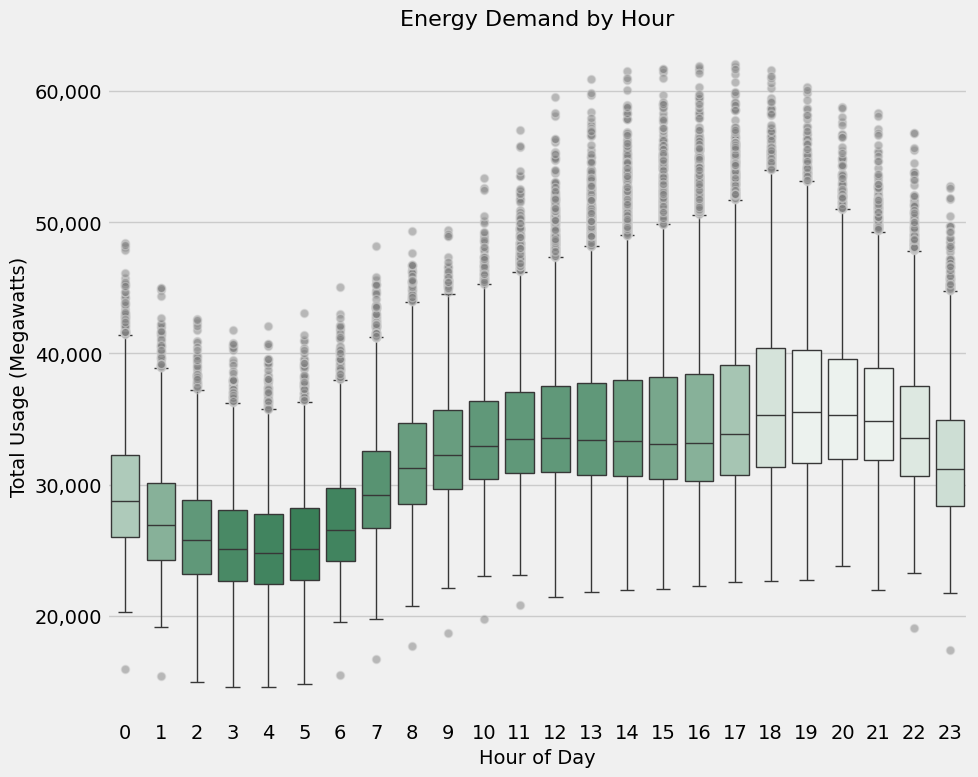

In [425]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# Rename columns for consistency
pjme_all = pjme_all.rename(columns={
    'Prediction': 'MW_Prediction',
    'Actual': 'PJME_MW'
})

# Calculate median MW value for each hour
hourly_median = pjme_all.groupby('hour')['PJME_MW'].median()

# Normalize the median values to create a scale between 0 and 1
normalized_median = (hourly_median - hourly_median.min()) / (hourly_median.max() - hourly_median.min())

# Generate color palette based on normalized median values
color_pal = sns.light_palette("seagreen", len(normalized_median))
hour_colors = {hour: color_pal[int(norm * (len(color_pal) - 1))] for hour, norm in zip(hourly_median.index, normalized_median)}

# Define a function for comma-delineated formatting
def comma_format(x, pos):
    return f'{x:,.0f}'

# Create the boxplot with enhancements
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(
    data=pjme_all, 
    x='hour', 
    y='PJME_MW', 
    palette=[hour_colors[hour] for hour in pjme_all['hour'].unique()],  # Apply dynamic colors
    flierprops={
        'marker': 'o', 
        'markerfacecolor': 'gray', 
        'markeredgecolor': 'lightgray', 
        'alpha': 0.5
    }
)

# Add title and format axes
ax.set_title('Energy Demand by Hour', fontsize=16)
ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Total Usage (Megawatts)', fontsize=14)

# Apply comma formatting to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(comma_format))

plt.tight_layout()
plt.show()



C:\Users\Owner\AppData\Local\Temp\ipykernel_41908\2908908186.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pjme_all, x='month', y='PJME_MW', palette='Blues')


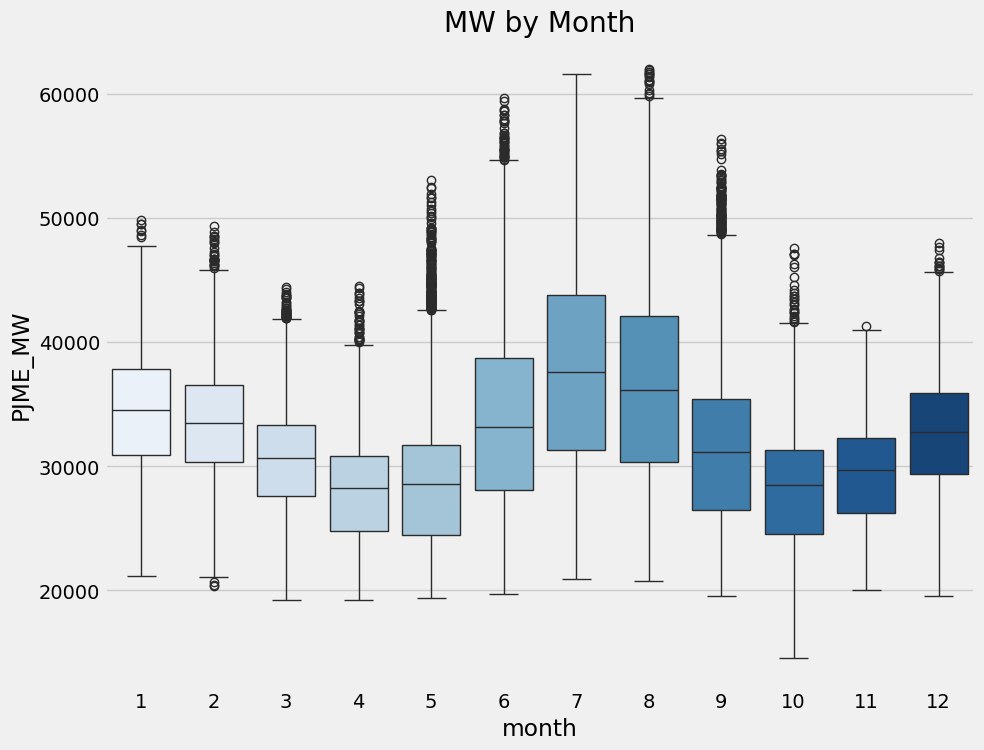

In [330]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=pjme_all, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

<Axes: ylabel='Frequency'>

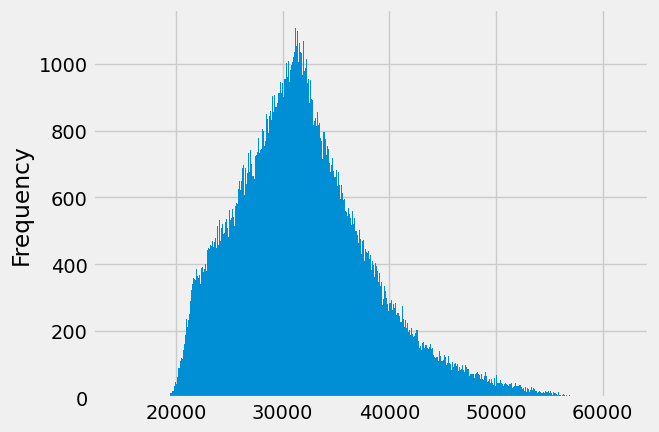

In [331]:
pjme_all['PJME_MW'].plot(kind='hist', bins=500)

In [332]:
df = pjme_all

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

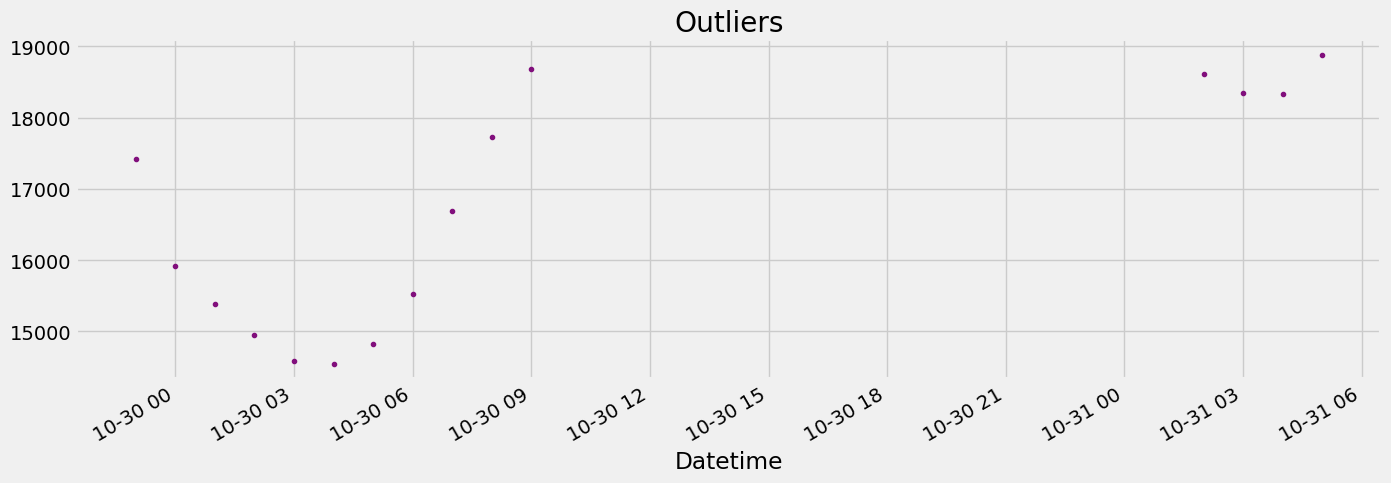

In [333]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [334]:
pjme_all.head()

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
Datetime,,,,,,,,,,,
2018-08-03 00:00:00,35486,2018-08-03 00:00:00,0,4,3,8,2018,215,3,31,31353.884766
2018-08-02 23:00:00,38500,2018-08-02 23:00:00,23,3,3,8,2018,214,2,31,32825.929688
2018-08-02 22:00:00,41552,2018-08-02 22:00:00,22,3,3,8,2018,214,2,31,36503.222656
2018-08-02 21:00:00,43256,2018-08-02 21:00:00,21,3,3,8,2018,214,2,31,38013.160156
2018-08-02 20:00:00,44057,2018-08-02 20:00:00,20,3,3,8,2018,214,2,31,39236.679688


## Time Series Cross Validation

In [336]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

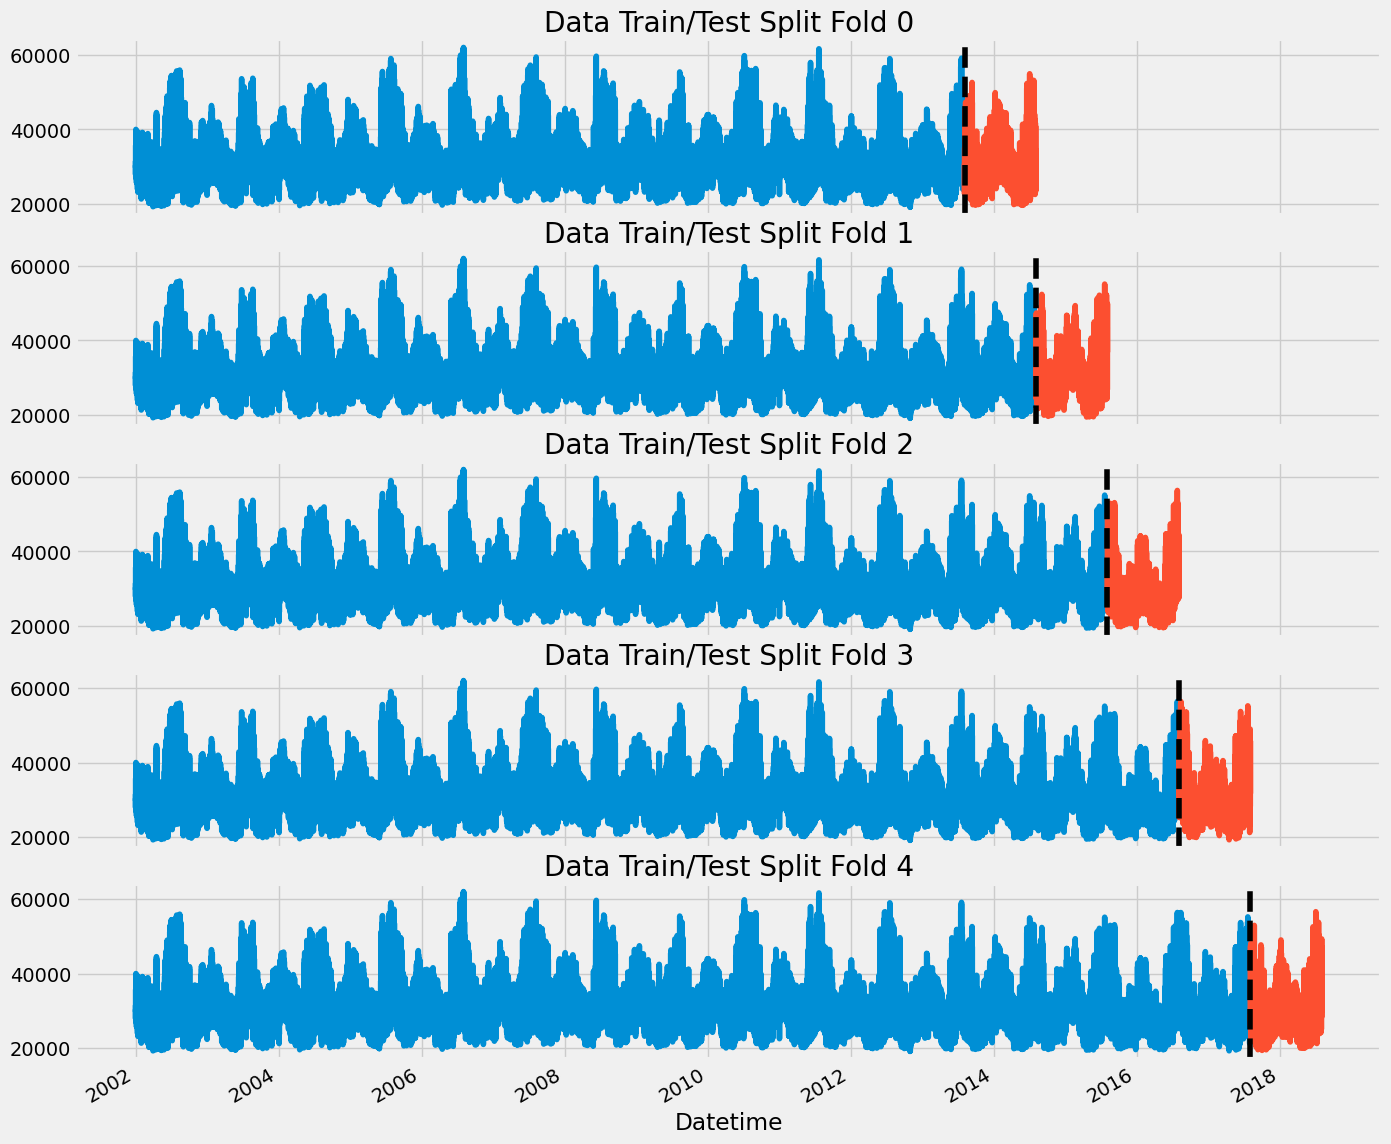

In [337]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [338]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [339]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [340]:
df = add_lags(df)

In [341]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


c:\Users\Owner\miniforge3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


c:\Users\Owner\miniforge3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


c:\Users\Owner\miniforge3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.72805
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.21239
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.40541
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.25153
[411]	validation_0-rmse:3475.26636	validation_1-rmse:3503.58192
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


c:\Users\Owner\miniforge3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.30026	validation_1-rmse:12019.98579
[200]	validation_0-rmse:5738.32648	validation_1-rmse:5794.44193
[300]	validation_0-rmse:3915.76448	validation_1-rmse:4385.51304
[400]	validation_0-rmse:3499.03653	validation_1-rmse:4172.17739
[500]	validation_0-rmse:3382.83569	validation_1-rmse:4116.88500
[600]	validation_0-rmse:3324.23232	validation_1-rmse:4104.49052
[700]	validation_0-rmse:3281.46398	validation_1-rmse:4088.11017
[800]	validation_0-rmse:3249.57813	validation_1-rmse:4081.68478
[900]	validation_0-rmse:3223.05405	validation_1-rmse:4071.81118
[999]	validation_0-rmse:3198.63557	validation_1-rmse:4048.63642
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


c:\Users\Owner\miniforge3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.92077	validation_1-rmse:11962.25620
[200]	validation_0-rmse:5752.09311	validation_1-rmse:5610.63120
[300]	validation_0-rmse:3953.20675	validation_1-rmse:4149.59785
[400]	validation_0-rmse:3541.03333	validation_1-rmse:3998.79808
[439]	validation_0-rmse:3482.74154	validation_1-rmse:4002.73223


In [342]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3740.5297
Fold scores:[3760.8277187583353, 3420.313091887879, 3477.9504020604863, 4048.636422781358, 3994.920732273779]


In [343]:
 # Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


c:\Users\Owner\miniforge3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.77634
[200]	validation_0-rmse:5753.18185
[300]	validation_0-rmse:3970.09392
[400]	validation_0-rmse:3569.04975
[499]	validation_0-rmse:3456.43359


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [344]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [345]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [346]:
future_w_features = df_and_future.query('isFuture').copy()

In [347]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

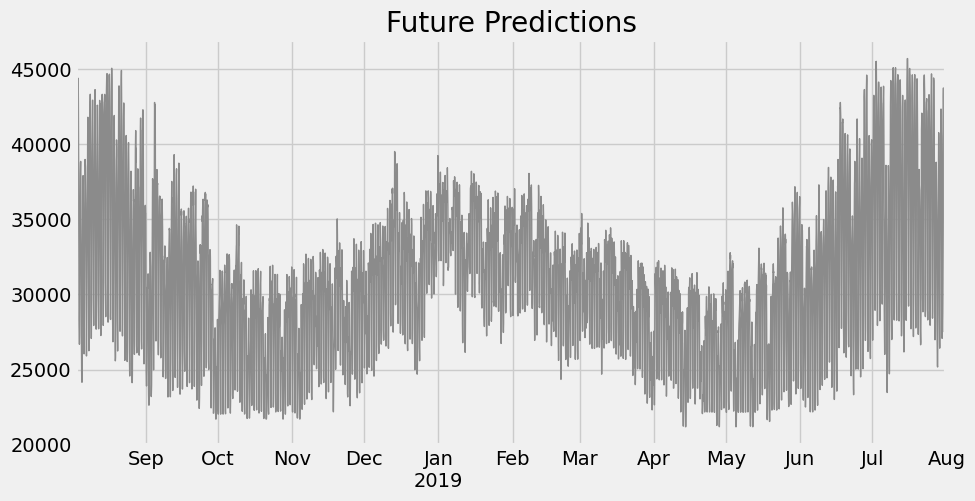

In [348]:
# Define bin size
bin_size = 20  # Number of data points per bin
binned_data = future_w_features['pred'].groupby(future_w_features.index // bin_size).mean()

# Plot the binned data
binned_data.plot(figsize=(10, 5),
                 color=color_pal[4],
                 ms=1,
                 lw=1,
                 title='Future Predictions (Binned)')
plt.show()


In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

NameError: name 'xgb' is not defined